In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras

import sys
# sys.path.append("/Users/Work/Developer/interpretDL/interprettensor")
root_logdir = "./tf_logs"

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

    
def get1hot(y_train,y_test):
    from sklearn.preprocessing import OneHotEncoder

    enc = OneHotEncoder(categories="auto", sparse=False)
    y_train_1hot = enc.fit_transform([[label] for label in y_train]) # Since the function expects an array of "features" per sample
    y_test_1hot = enc.fit_transform([[label] for label in y_test])

    return y_train_1hot, y_test_1hot
    
tf.__version__

Using TensorFlow backend.


'1.12.0'

### Getting data from csv

In [2]:
filename = "cleaned_ADNI.csv"
raw_data = pd.read_csv(filename)
print(raw_data.info())
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Columns: 299 entries, PTID to DX_bl
dtypes: float64(148), int64(148), object(3)
memory usage: 334.1+ KB
None


,PTID,scandate,G_and_S_frontomargin_SA_lh,G_and_S_frontomargin_TH_lh,G_and_S_occipital_inf_SA_lh,G_and_S_occipital_inf_TH_lh,G_and_S_paracentral_SA_lh,G_and_S_paracentral_TH_lh,G_and_S_subcentral_SA_lh,G_and_S_subcentral_TH_lh,...,S_suborbital_TH_rh,S_subparietal_SA_rh,S_subparietal_TH_rh,S_temporal_inf_SA_rh,S_temporal_inf_TH_rh,S_temporal_sup_SA_rh,S_temporal_sup_TH_rh,S_temporal_transverse_SA_rh,S_temporal_transverse_TH_rh,DX_bl
0,094_S_2216,2011-05-04 08:35:04.461,936,1.984,1158,2.107,993,2.306,1226,2.359,...,1.421,1007,1.937,763,1.759,4349,2.025,249,1.579,EMCI
1,029_S_2376,2011-07-05 18:17:58.518,855,2.160,1291,2.287,1137,1.961,1451,2.059,...,2.457,1195,1.804,635,1.970,4895,2.071,344,1.642,EMCI
2,098_S_4003,2016-05-04 15:44:47.525,849,2.122,909,2.272,788,2.430,717,2.606,...,2.222,626,1.870,784,1.826,3182,2.056,195,2.179,CN
3,021_S_2077,2014-10-21 15:26:50.834,762,2.237,969,2.141,1153,2.130,1156,2.135,...,2.880,1127,2.245,789,1.924,4399,2.014,243,1.826,EMCI
4,021_S_5099,2013-06-11 14:47:47.885,752,2.073,960,2.521,873,2.374,810,2.481,...,3.412,790,2.276,665,2.535,2914,2.168,183,2.166,EMCI


**Should do some form of test train split**

We'll start with a (stratified) shuffle split for now. Startified sampling ensures that **test** set has the correct representation of each category.

Later move on to K-Folds to really test out the network...

# IDEAS

## How about make it CN vs AD only


### How about we fuse some of the classes - wont reduce samples
> NC = NC + SMC -> just fuse them 

> MCI = EMCI + LMCI

> AD

### Try removing SA from the features
> Just keep Thickness

#### Add hippocampus volumes L and R
> from aseg.stat

> Also add up all volumes in aseg.stat and add up to get ICV intra cranial volume

### Instead could normalize the thickness by ICV (divide them by ICV value)
> Note that ICV = mm^3 and thickness = mm, so divide by ICV^(1/3)


### > Balancing the training set -> SMOTE
- look at scikit learn, scipy
- just do it in feature space
- will interpolate samples to balance the classes


### ANOTHER approach is to ** pretrain ** if nothing else works
- Pretrain on all 600 samples
- Freeze all but the last two layers and retrain on 143 dataset
- Make sure that test set is never seen, eevn in pretraining

In [18]:
label_col = "DX_bl"
features = raw_data.drop(columns=["PTID", "scandate",label_col])
raw_labels = raw_data[label_col].copy()
features.head()

,G_and_S_frontomargin_SA_lh,G_and_S_frontomargin_TH_lh,G_and_S_occipital_inf_SA_lh,G_and_S_occipital_inf_TH_lh,G_and_S_paracentral_SA_lh,G_and_S_paracentral_TH_lh,G_and_S_subcentral_SA_lh,G_and_S_subcentral_TH_lh,G_and_S_transv_frontopol_SA_lh,G_and_S_transv_frontopol_TH_lh,...,S_suborbital_SA_rh,S_suborbital_TH_rh,S_subparietal_SA_rh,S_subparietal_TH_rh,S_temporal_inf_SA_rh,S_temporal_inf_TH_rh,S_temporal_sup_SA_rh,S_temporal_sup_TH_rh,S_temporal_transverse_SA_rh,S_temporal_transverse_TH_rh
0,936,1.984,1158,2.107,993,2.306,1226,2.359,443,2.338,...,254,1.421,1007,1.937,763,1.759,4349,2.025,249,1.579
1,855,2.160,1291,2.287,1137,1.961,1451,2.059,685,2.207,...,309,2.457,1195,1.804,635,1.970,4895,2.071,344,1.642
2,849,2.122,909,2.272,788,2.430,717,2.606,474,2.456,...,250,2.222,626,1.870,784,1.826,3182,2.056,195,2.179
3,762,2.237,969,2.141,1153,2.130,1156,2.135,421,2.282,...,180,2.880,1127,2.245,789,1.924,4399,2.014,243,1.826
4,752,2.073,960,2.521,873,2.374,810,2.481,460,2.331,...,197,3.412,790,2.276,665,2.535,2914,2.168,183,2.166


In [23]:
# Getting all the columns related to surface area
thickness_features = [x for x in features.columns if "SA" in x ]

# Removing SA to reduce feature dimensions
raw_features = features.drop(columns=thickness_features)

raw_features.head()

,G_and_S_frontomargin_TH_lh,G_and_S_occipital_inf_TH_lh,G_and_S_paracentral_TH_lh,G_and_S_subcentral_TH_lh,G_and_S_transv_frontopol_TH_lh,G_and_S_cingul-Ant_TH_lh,G_and_S_cingul-Mid-Ant_TH_lh,G_and_S_cingul-Mid-Post_TH_lh,G_cingul-Post-dorsal_TH_lh,G_cingul-Post-ventral_TH_lh,...,S_parieto_occipital_TH_rh,S_pericallosal_TH_rh,S_postcentral_TH_rh,S_precentral-inf-part_TH_rh,S_precentral-sup-part_TH_rh,S_suborbital_TH_rh,S_subparietal_TH_rh,S_temporal_inf_TH_rh,S_temporal_sup_TH_rh,S_temporal_transverse_TH_rh
0,1.984,2.107,2.306,2.359,2.338,2.185,2.351,2.294,2.656,2.034,...,1.836,2.148,1.731,2.309,1.984,1.421,1.937,1.759,2.025,1.579
1,2.160,2.287,1.961,2.059,2.207,2.371,2.121,1.987,2.289,2.060,...,1.692,1.832,1.589,2.189,1.861,2.457,1.804,1.970,2.071,1.642
2,2.122,2.272,2.430,2.606,2.456,2.541,2.580,2.276,2.578,2.291,...,1.977,2.623,1.882,2.192,2.071,2.222,1.870,1.826,2.056,2.179
3,2.237,2.141,2.130,2.135,2.282,2.218,2.213,2.332,2.985,2.224,...,1.749,2.065,1.882,2.071,2.104,2.880,2.245,1.924,2.014,1.826
4,2.073,2.521,2.374,2.481,2.331,2.854,2.854,2.533,3.032,2.412,...,2.118,2.887,1.862,2.146,2.238,3.412,2.276,2.535,2.168,2.166


In [24]:
raw_labels.value_counts()/len(raw_labels)

EMCI    0.321678
CN      0.209790
AD      0.181818
LMCI    0.146853
SMC     0.139860
Name: DX_bl, dtype: float64

## Fusing all the columns

In [25]:
# Mapping to convert labels
fuse_maps = {"SMC": "CN", "EMCI":"MCI", "LMCI":"MCI"}

# Lambda fucntion to be used with Map func
fuse = lambda x: fuse_maps[x] if x in fuse_maps else x

fused_labels = list(map(fuse, raw_labels))

In [26]:
print("Sample Size:", len(fused_labels))
pd.Series(fused_labels).value_counts()/len(fused_labels)

Sample Size: 143


MCI    0.468531
CN     0.349650
AD     0.181818
dtype: float64

## Using SMOTE

> Generates interpolated samples to balance training data 

In [33]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

features, labels = sm.fit_resample(raw_features, fused_labels)

print(features.shape)
print(pd.Series(labels).value_counts()/len(labels))
len(labels)

(201, 148)
MCI    0.333333
CN     0.333333
AD     0.333333
dtype: float64


201

### Get 1 Hot Vector representation of the *fused* categorical labels

In [35]:
# Converting labels to 1-Hot Vectors
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(categories="auto", sparse=False)
labels_1hot = enc.fit_transform([[label] for label in labels]) # Since the function expects an array of "features" per sample

print("Categories:", enc.categories_)

print(y[:5])
labels_1hot[:5]

Categories: [array(['AD', 'CN', 'MCI'], dtype=object)]
['MCI' 'MCI' 'CN' 'MCI' 'MCI']


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

# Normalizing training inputs

Does not work at all without normalization. The ranges for surface area and thickness are vastly different.

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #x-u/sd
features = scaler.fit_transform(features) # Note that features is no longer a dataframe

In [37]:
from sklearn.model_selection import StratifiedShuffleSplit

# The train set will have equal amounts of each target class
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(features, labels):
    X_train = features[train_index]
    y_train_1hot = labels_1hot[train_index]
    X_test = features[test_index]
    y_test_1hot = labels_1hot[test_index]

In [42]:
print("Train Size:", X_train.shape)
# print(y_test_1hot)

Train Size: (160, 148)


### Building the network

We will build a fully connected (slightly) deep network with no drop outs or batch normalization for now

In [63]:
from keras import optimizers
from keras import regularizers

def build_dnn(num_features):
    keras.backend.clear_session()
    reset_graph()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1_l2(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = tf.contrib.layers.variance_scaling_initializer()
    # he_init =keras.initializers.VarianceScaling()

    dnn.add(Dense(units = 300, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 150, activation="elu",
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=50, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.1))
    
    dnn.add(Dense(units=3, activation="softmax", kernel_initializer=he_init)) # 5 labels -> logits for now

    dnn.compile(loss='categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
    
    return dnn

dnn = build_dnn(X_train.shape[1])
dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               44700     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               45150     
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                7550      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 153       
Total para

In [64]:
dnn = build_dnn(X_train.shape[1])
history = dnn.fit(X_train, y_train_1hot, epochs=50, batch_size = 30, validation_data=(X_test, y_test_1hot))

Train on 160 samples, validate on 41 samples
Epoch 1/50
160/160 [==============================] - 0s 3ms/step - loss: 21.0634 - acc: 0.4063 - val_loss: 19.3637 - val_acc: 0.4634
Epoch 2/50
160/160 [==============================] - 0s 104us/step - loss: 19.7533 - acc: 0.4875 - val_loss: 19.1144 - val_acc: 0.4878
Epoch 3/50
160/160 [==============================] - 0s 99us/step - loss: 18.9354 - acc: 0.5875 - val_loss: 18.8445 - val_acc: 0.4878
Epoch 4/50
160/160 [==============================] - 0s 109us/step - loss: 18.8127 - acc: 0.5875 - val_loss: 18.6904 - val_acc: 0.4878
Epoch 5/50
160/160 [==============================] - 0s 119us/step - loss: 18.5296 - acc: 0.6438 - val_loss: 18.4493 - val_acc: 0.5854
Epoch 6/50
160/160 [==============================] - 0s 120us/step - loss: 18.1562 - acc: 0.6500 - val_loss: 18.2054 - val_acc: 0.6341
Epoch 7/50
160/160 [==============================] - 0s 120us/step - loss: 17.8117 - acc: 0.7437 - val_loss: 18.0247 - val_acc: 0.5854
Epoch 

0.7560975667906971


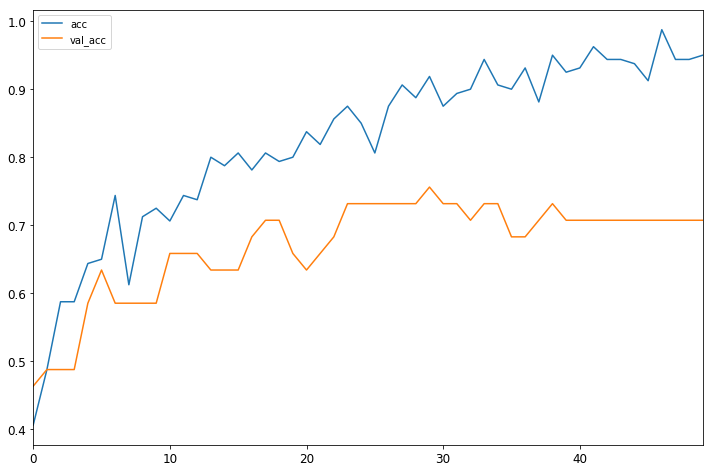

In [65]:
df = pd.DataFrame(history.history)
print(max(df["val_acc"]))
df[["acc","val_acc"]].plot(figsize=(12,8))

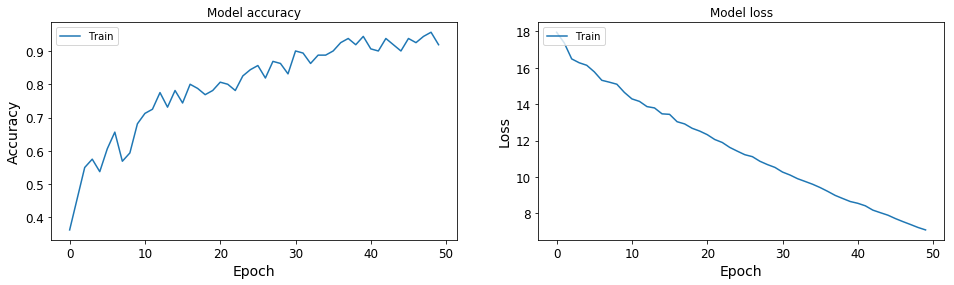

In [54]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(16,4))

    # Plot training & validation accuracy values
    axs[0].plot(history.history['acc'])
    # plt.plot(history.history['val_acc'])
    axs[0].set(title='Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'])
    # plt.plot(history.history['val_loss'])
    axs[1].set(title='Model loss',ylabel='Loss', xlabel='Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')
    plt.show()

plot_history(history)

In [111]:
loss_and_metrics = dnn.evaluate(X_test, y_test_1hot)
print("Scores on test set: loss={:0.3f} accuracy={:.4f}".format(*loss_and_metrics))

29/29 [==============================] - 0s 49us/step
Scores on test set: loss=18.694 accuracy=0.2414


In [110]:
loss_and_metrics = dnn.evaluate(features, labels_1hot)
print("Scores on test set: loss={:0.3f} accuracy={:.4f}".format(*loss_and_metrics))

143/143 [==============================] - 0s 47us/step
Scores on test set: loss=15.086 accuracy=0.8462


In [112]:
features.shape

(143, 296)

In [108]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
num_features = features.shape[1]

for train_index, test_index in kf.split(features):
    X_train = features[train_index]
    y_train_1hot = labels_1hot[train_index]
    X_test = features[test_index]
    y_test_1hot = labels_1hot[test_index]
    
    dnn = build_dnn(num_features)
    history = dnn.fit(X_train, y_train_1hot, epochs=30, batch_size = 20, validation_data=(X_test, y_test_1hot))
    print("-----"*10)

Train on 128 samples, validate on 15 samples
Epoch 1/30
128/128 [==============================] - 0s 3ms/step - loss: 3.0956 - acc: 0.2266 - val_loss: 1.6730 - val_acc: 0.2667
Epoch 2/30
128/128 [==============================] - 0s 133us/step - loss: 1.9500 - acc: 0.4297 - val_loss: 1.5568 - val_acc: 0.3333
Epoch 3/30
128/128 [==============================] - 0s 160us/step - loss: 1.3267 - acc: 0.5547 - val_loss: 1.6679 - val_acc: 0.2667
Epoch 4/30
128/128 [==============================] - 0s 148us/step - loss: 1.0680 - acc: 0.6172 - val_loss: 1.5336 - val_acc: 0.3333
Epoch 5/30
128/128 [==============================] - 0s 149us/step - loss: 0.9756 - acc: 0.6562 - val_loss: 1.6343 - val_acc: 0.2000
Epoch 6/30
128/128 [==============================] - 0s 159us/step - loss: 0.7541 - acc: 0.6797 - val_loss: 1.7983 - val_acc: 0.2000
Epoch 7/30
128/128 [==============================] - 0s 156us/step - loss: 0.7241 - acc: 0.7344 - val_loss: 1.8254 - val_acc: 0.3333
Epoch 8/30
128/128 